In [14]:
import os
# change working direction to current location
# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
os.chdir(current_dir)
import sys
# to include utility directory
sys.path.append('./_utils/')
sys.path.append('./_utils/torchKAN')
os.environ['PYTHONPATH'] = os.path.join(current_dir, '_utils')
os.environ['PYTHONPATH'] = os.path.join(current_dir, '_utils/torchKAN')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import timeit
import time

from kans import KAN
# from torchkan import KAN
# from KACnet import KAC_Net

import random

use_cuda = False
if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

def set_seed(seed):
    # fix seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(1234)

Using device: cpu


ChebyKan 

In [15]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        # Since Chebyshev polynomial is defined in [-1, 1]
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim, 1)).expand(
            -1, -1, self.degree + 1
        )  # shape = (batch_size, inputdim, self.degree + 1)
        # Apply acos
        epsilon = 1e-6
        x = torch.clamp(x, -1 + epsilon, 1 - epsilon)
        x = x.acos()
        # Multiply by arange [0 .. degree]
        x *= self.arange
        # Apply cos
        x = x.cos()
        # Compute the Chebyshev interpolation
        y = torch.einsum(
            "bid,iod->bo", x, self.cheby_coeffs
        )  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)
        return y
    
class ChebyKAN(nn.Module):
    def __init__(self, layer_sizes, num_chebyshev_terms=8):
        super(ChebyKAN, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(ChebyKANLayer(layer_sizes[i], layer_sizes[i+1], num_chebyshev_terms))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
    def model_size(self):
        # count the number of parameters in the model
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

MLP

In [16]:
class SimpleMLP(nn.Module):
    def __init__(self, layer_sizes):
        super(SimpleMLP, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Apply activation function to all but the last layer
                layers.append(nn.Tanh())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)*1000  # centralize the input
    
    def model_size(self):
        # count the number of parameters in the model
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

FFNN & ResNet

In [17]:
# placeholder for FFNN and ResNet

Target Function

In [18]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    # noise = np.random.normal(0, 0.2, y.shape)
    # y += noise

    return y*1000 

In [19]:
# error metrics class for evaluating the error of the solution
class ErrorMetrics:
    def __init__(self, u_pred, u_true):
        self.u_true = u_true
        self.u_pred = u_pred
        self.N = u_true.shape[0]

    def RMSE(self): # root mean squared error
        return np.sqrt(np.mean((self.u_pred - self.u_true)**2))

    def MAE(self): # mean absolute error
        return np.mean(np.abs(self.u_pred - self.u_true))

    def MAPE(self): # mean absolute percentage error
        with np.errstate(divide='ignore'):
            return np.mean(np.abs((self.u_pred - self.u_true)/self.u_true))*100

    def NRMSPE(self): # normalized root mean squared error in percent
        return np.sqrt(np.mean((self.u_pred - self.u_true)**2)/np.mean(self.u_true**2))*100

    def NMAPE(self): # normalized mean absolute error or weighted mean absolute percentage error in percent
        return np.mean(np.abs(self.u_pred - self.u_true)/np.mean(self.u_true))*100

main function

In [ ]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train)).to(device)
x_train = x_train.to(device)

# Instantiate models
full_layers = [1, 20, 20, 1]
grid_size=10; spline_order=3; base_activation=torch.nn.Tanh;
# scale_noise=0.1
# scale_base=1.0
# scale_spline=1.0
# grid_eps=0.02
# grid_range=[-1, 1]
kan_model = KAN(layers_hidden = full_layers, grid_size=grid_size, spline_order=spline_order, base_activation= base_activation).to(device)
cheby_model = ChebyKAN(full_layers).to(device)

full_layers = [1, 128, 128, 1]
mlp_model = SimpleMLP(full_layers).to(device)


print('Total number of parameters of KST + Spline: %d' % (kan_model.model_size()))
print('Total number of parameters of KST + Polynomial: %d' % (cheby_model.model_size()))
print('Total number of parameters of MLP: %d' % (mlp_model.model_size()), '\n')


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_kan = torch.optim.Adam(kan_model.parameters(), lr=0.01)
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)


kan_losses = []
cheby_losses = []
mlp_losses = []


adam_total_time_kan = 0
adam_total_time_chebykan = 0
adam_total_time_mlp = 0


lbfgs_total_time_kan = 0
lbfgs_total_time_chebykan = 0
lbfgs_total_time_mlp = 0


# Train the models
epochs = 10000
# Define arguments outside the closure
def train_step(model, optimizer, x_train, y_train):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(epochs):

    start_time_kan = time.time()
    loss_kan = train_step(kan_model, optimizer_kan, x_train, y_train)
    end_time_kan =time.time()
    adam_total_time_kan += (end_time_kan - start_time_kan)

    start_time_cheby = time.time()
    loss_cheby = train_step(cheby_model, optimizer_cheby, x_train, y_train)
    end_time_cheby =time.time()
    adam_total_time_chebykan += (end_time_cheby - start_time_cheby)

    start_time_mlp = time.time()
    loss_mlp = train_step(mlp_model, optimizer_mlp, x_train, y_train)
    end_time_mlp =time.time()
    adam_total_time_mlp += (end_time_mlp - start_time_mlp)



    if epoch % 100 == 0:
        kan_losses.append(loss_cheby.item())
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
       
        print(f'Epoch {epoch + 1}/{epochs}, KST + Spline Loss: {loss_kan.item():.8f}, KST + Polynomial Loss: {loss_cheby.item():.8f}, MLP Loss: {loss_mlp.item():.8f}')


# bfgs training
max_iter = 100
optimizer_kan = torch.optim.LBFGS(kan_model.parameters(),
                    history_size=10,
                    max_iter=max_iter,
                    line_search_fn="strong_wolfe")
optimizer_cheby = torch.optim.LBFGS(cheby_model.parameters(),
                    history_size=10,
                    max_iter=max_iter,
                    line_search_fn="strong_wolfe")
optimizer_mlp = torch.optim.LBFGS(mlp_model.parameters(),
                    history_size=10,
                    max_iter=max_iter,
                    line_search_fn="strong_wolfe")


# Train the models
# Define arguments outside the closure
def train_step(model, optimizer, x_train, y_train):
    def closure():
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        if loss.requires_grad:
            loss.backward()
        return loss
    return closure

epochs = 500
for epoch in range(epochs):
    # Pass the arguments by setting up the closures
    start_time_kan = time.time()
    closure_kan = train_step(kan_model, optimizer_kan, x_train, y_train)
    optimizer_kan.step(closure_kan)
    end_time_kan =time.time()
    lbfgs_total_time_kan += (end_time_kan - start_time_kan)

    start_time_cheby = time.time()
    closure_cheby = train_step(cheby_model, optimizer_cheby, x_train, y_train)
    optimizer_cheby.step(closure_cheby)
    end_time_cheby =time.time()
    lbfgs_total_time_chebykan += (end_time_cheby - start_time_cheby)

    start_time_mlp = time.time()
    closure_mlp = train_step(mlp_model, optimizer_mlp, x_train, y_train)
    optimizer_mlp.step(closure_mlp)
    end_time_mlp =time.time()
    lbfgs_total_time_mlp += (end_time_mlp - start_time_mlp)

    if epoch % 10 == 0:
        loss_kan = closure_kan()
        loss_cheby = closure_cheby()
        loss_mlp = closure_mlp()
        
        kan_losses.append(loss_cheby.item())
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        
        print(f'Epoch {epoch + 1}/{epochs}, KST + Spline Loss/time: {loss_kan.item():.8f}/{lbfgs_total_time_kan:.1e}, KST + Polynomial Loss: {loss_cheby.item():.8f}/{lbfgs_total_time_chebykan:.1e}, MLP Loss: {loss_mlp.item():.8f}/{lbfgs_total_time_mlp:.1e}')

print('Adam:')
print(f"KST + Polynomial calculation time: {adam_total_time_chebykan:.4f} seconds")
print(f"MLP calculation time: {adam_total_time_mlp:.4f} seconds")
print(f"KST + Spline calculation time: {adam_total_time_kan:.4f} seconds")


print('LBFGS:')
print(f"KST + Polynomial calculation time: {lbfgs_total_time_chebykan:.4f} seconds")
print(f"MLP calculation time: {lbfgs_total_time_mlp:.4f} seconds")
print(f"KST + Spline calculation time: {lbfgs_total_time_kan:.4f} seconds")


# # Test the models
# x_test = torch.linspace(0, 2, steps=400).unsqueeze(1).to(device)
# y_pred_kan = cheby_model(x_test).detach().cpu()
# y_pred_cheby = cheby_model(x_test).detach().cpu()
# y_pred_mlp = mlp_model(x_test).detach().cpu()



Total number of parameters of KST + Spline: 6600
Total number of parameters of KST + Polynomial: 3960
Total number of parameters of MLP: 16897 

Epoch 1/10000, KST + Spline Loss: 597444.50000000, KST + Polynomial Loss: 597502.25000000, MLP Loss: 532459.75000000
Epoch 101/10000, KST + Spline Loss: 570332.56250000, KST + Polynomial Loss: 505155.75000000, MLP Loss: 190952.79687500
Epoch 201/10000, KST + Spline Loss: 530034.68750000, KST + Polynomial Loss: 432714.90625000, MLP Loss: 186388.79687500
Epoch 301/10000, KST + Spline Loss: 454169.25000000, KST + Polynomial Loss: 337342.43750000, MLP Loss: 185325.31250000
Epoch 401/10000, KST + Spline Loss: 180057.79687500, KST + Polynomial Loss: 255852.50000000, MLP Loss: 184868.25000000
Epoch 501/10000, KST + Spline Loss: 69317.78125000, KST + Polynomial Loss: 211732.70312500, MLP Loss: 184202.95312500
Epoch 601/10000, KST + Spline Loss: 37183.55468750, KST + Polynomial Loss: 178092.18750000, MLP Loss: 183186.10937500
Epoch 701/10000, KST + Spl

In [ ]:
# Test the models
with torch.no_grad():
    y_pred_cheby = cheby_model(x_test).cpu().detach().numpy()
    y_pred_mlp = mlp_model(x_test).cpu().detach().numpy()
    y_pred_kan = kan_model(x_test).cpu().detach().numpy()

# Calculate and print errors for ChebyKAN (as an example)
y_test = target_function(x_test.cpu().numpy())

cheby_error_u = ErrorMetrics(y_pred_cheby, y_test)
mlp_error_u = ErrorMetrics(y_pred_mlp, y_test)
kan_error_u = ErrorMetrics(y_pred_kan, y_test)


print('Relative/normalized RMSE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.NRMSPE()))
print('MLP: %.8f' % (mlp_error_u.NRMSPE()))
print('KST + Sp: %.8f' % (kan_error_u.NRMSPE()))
print('\n')


print('Relative/normalized NMAPE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.NMAPE()))
print('MLP: %.8f' % (mlp_error_u.NMAPE()))
print('KST + Spline: %.8f' % (kan_error_u.NMAPE()))
print('\n')


print('MAPE (percent)')
print('KST + Polynomial: %.8f' % (cheby_error_u.MAPE()))
print('MLP: %.8f' % (mlp_error_u.MAPE()))
print('KST + Spline: %.8f' % (kan_error_u.MAPE()))
print('\n')


print('RMSE')
print('KST + Polynomial %.8f' % (cheby_error_u.RMSE()))
print('MLP: %.8f' % (mlp_error_u.RMSE()))
print('KST + Spline: %.8f' % (kan_error_u.RMSE()))
print('\n')


print('MAE')
print('KST + Polynomial: %.8f' % (cheby_error_u.MAE()))
print('MLP: %.8f' % (mlp_error_u.MAE()))
print('KST + Spline: %.8f' % (kan_error_u.MAE()))
print('\n')

Relative/normalized RMSE (percent)
KST + Polynomial: 3.98057252
MLP: 0.95965480
KST + Sp: 1.90236550


Relative/normalized NMAPE (percent)
KST + Polynomial: 4.67833988
MLP: 1.26571087
KST + Spline: 1.57957394


MAPE (percent)
KST + Polynomial: inf
MLP: inf
KST + Spline: inf


RMSE
KST + Polynomial 30.77597046
MLP: 7.41961288
KST + Spline: 14.70822144


MAE
KST + Polynomial: 14.76972771
MLP: 3.99590588
KST + Spline: 4.98678493




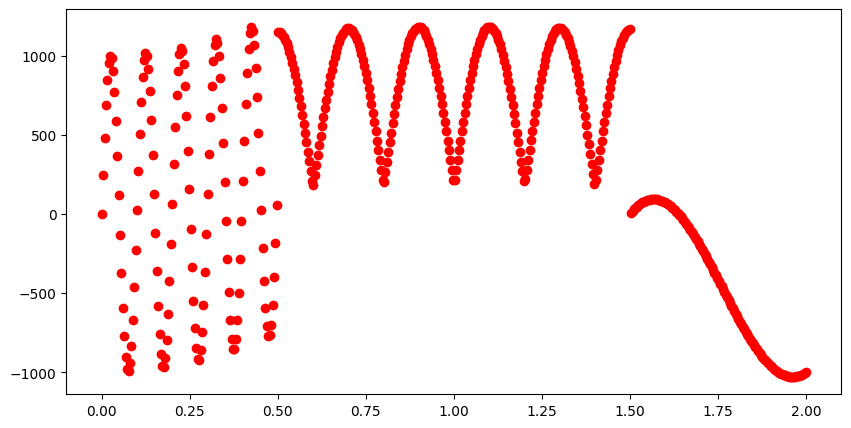

In [ ]:
# Define the folder where you want to save the figures
output_folder = 'KAN_test_figures'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'ro', label='Original Data')

plot results

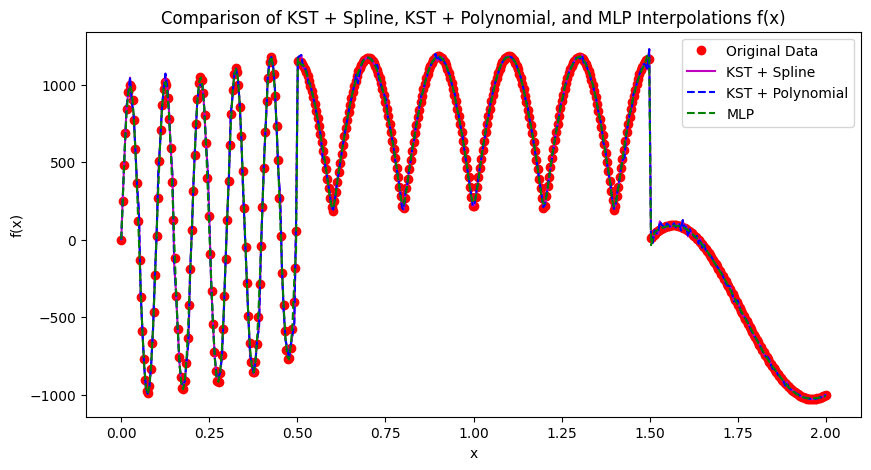

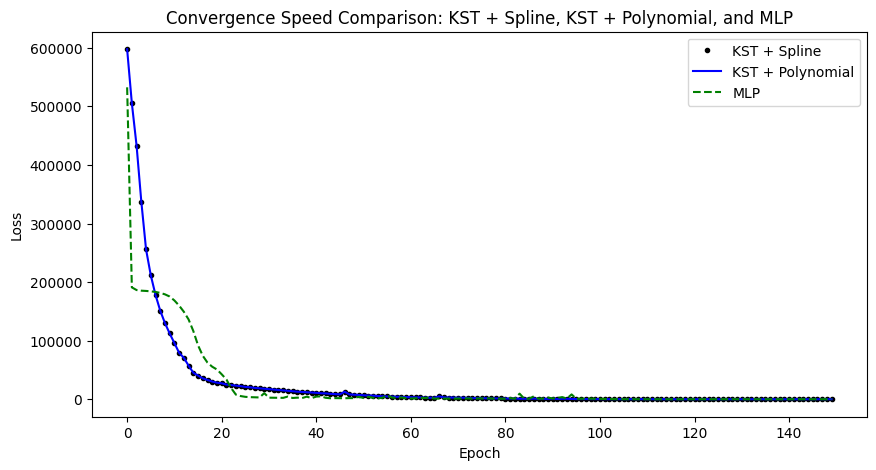

In [ ]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'ro', label='Original Data')
plt.plot(x_test.cpu().numpy(), y_pred_kan.cpu().numpy(), 'm-', label='KST + Spline')
plt.plot(x_test.cpu().numpy(), y_pred_kan.cpu().numpy(), 'b--', label='KST + Polynomial')
plt.plot(x_test.cpu().numpy(), y_pred_mlp.cpu().numpy(), 'g--', label='MLP')

plt.title('Comparison of KST + Spline, KST + Polynomial, and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.savefig(os.path.join(output_folder, 'KST_predictions.png'), dpi=300)  # Save as PNG file with 300 DPI resolution
plt.show()

# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0,len(kan_losses)), kan_losses, 'k.', label='KST + Spline')
plt.plot(np.arange(0,len(cheby_losses)), cheby_losses, 'b-', label='KST + Polynomial')
plt.plot(np.arange(0,len(mlp_losses)), mlp_losses, 'g--', label='MLP')

plt.title('Convergence Speed Comparison: KST + Spline, KST + Polynomial, and MLP')
# plt.xlim(900, 30000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(output_folder, 'KST_convergence.png'), dpi=300)  # Save as PNG file with 300 DPI resolution
plt.show()

150
150
150


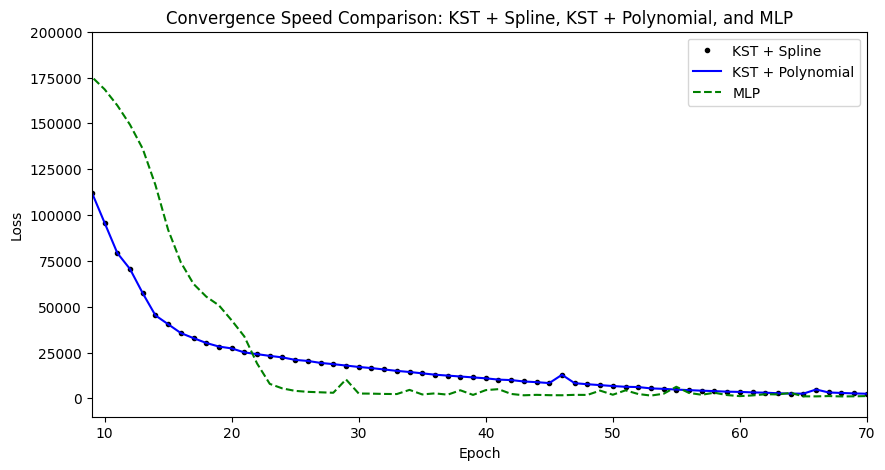

In [ ]:
print(len(mlp_losses))
print(len(cheby_losses))
print(len(kan_losses))


plt.figure(figsize=(10, 5))
plt.plot(np.arange(0,len(kan_losses)), kan_losses, 'k.', label='KST + Spline')
plt.plot(np.arange(0,len(cheby_losses)), cheby_losses, 'b-', label='KST + Polynomial')
plt.plot(np.arange(0,len(mlp_losses)), mlp_losses, 'g--', label='MLP')

plt.title('Convergence Speed Comparison: KST + Spline, KST + Polynomial, and MLP')
plt.ylim(-10000, 200000)
plt.xlim(9, 70)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(os.path.join(output_folder, 'ffnn_aal_time_convergence.png'), dpi=300)  # Save as PNG file with 300 DPI resolution
plt.show()